# Importing neccessary libraries and dataset

In [1]:
!pip install contractions
!pip install nltk
!pip install autocorrect 
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import string # from some string manipulation tasks
import nltk # natural language toolkit
import re # regex
from string import punctuation # solving punctuation problems
from nltk.corpus import stopwords # stop words in sentences
from nltk.stem import WordNetLemmatizer # For stemming the sentence
from nltk.stem import SnowballStemmer # For stemming the sentence
from contractions import contractions_dict # to solve contractions
from autocorrect import Speller #correcting the spellings
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

#Libraries for general purpose
import matplotlib.pyplot as plt
import seaborn as sns


#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import numpy as np
import pandas as pd

df = pd.read_csv('/content/cyberbullying_tweets.csv')
df['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

In [40]:
df.head

<bound method NDFrame.head of                                                     text  sentiment  \
0      In other words #katandandre, your food was cra...          4   
1      Why is #aussietv so white? #MKR #theblock #ImA...          4   
2      @XochitlSuckkks a classy whore? Or more red ve...          4   
3      @Jason_Gio meh. :P  thanks for the heads up, b...          4   
4      @RudhoeEnglish This is an ISIS account pretend...          4   
...                                                  ...        ...   
47687  Black ppl aren't expected to do anything, depe...          3   
47688  Turner did not withhold his disappointment. Tu...          3   
47689  I swear to God. This dumb nigger bitch. I have...          3   
47690  Yea fuck you RT @therealexel: IF YOURE A NIGGE...          3   
47691  Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...          3   

                                              text_clean  text_len  
0                     word katandandr food crapi

**There is not much imbalance between different cyberbulling type. other_cyberbulling will be removed since it may cause a confusion for the models with other cyberbullying class.**

In [4]:
df.drop(df[df['cyberbullying_type'] == 'other_cyberbullying'].index, inplace = True)
df['cyberbullying_type'].value_counts()

religion             7998
age                  7992
gender               7973
ethnicity            7961
not_cyberbullying    7945
Name: cyberbullying_type, dtype: int64

# Dataset Preprocessing

In [5]:
# Renaming Categories
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

In [6]:
# Checking 10 samples
df.sample(10)

,text,sentiment
45506,"Your right on the first point, I’ll apologise ...",ethnicity
39139,Rebecca black was bullied too much and is now ...,age
35400,You know I ain’t lying... Columbia High School...,age
11581,Idk if it was the gay jokes or the Cosby rape ...,gender
18961,@cdnKhadija @johnnygjokaj @rfrankh53 @98Halima...,religion
41567,these hoes like niggas that spend money not t...,ethnicity
17580,Ask about this to every Muslim you meet tomorr...,religion
12542,The same people who say rape joke aren't funny...,gender
6489,#Rejectedkidsbooks The idiot's guide to bullying,not_cyberbullying
32632,I think Biden should refuse to debate trump. W...,age


**Converting categories into numbers**

In [7]:
df["sentiment"].replace({"religion": 1, "age": 2, "gender": 3, "ethnicity": 4, "not_cyberbullying": 5}, inplace=True)

In [10]:
sentiments = ["religion","age","gender","ethnicity","not_cyberbullying"]

**Preprocessing: Tokenize sentences, Change to lower case, Correct spelling, Remove numbers, Remove punctuation, Remove stopwords, Normalize (Lemmatize or Lemmatization)**

In [11]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Predefined functions for text cleaning**

In [12]:
#@title

#Text cleaning
import re, string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14) # remove words longer than 14 characters
    return text

#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

#Stemming
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

#Lemmatization 
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

#Then we apply all the defined functions in the following order
def preprocess(text):
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text

In [13]:
texts_cleaned = []
for t in df.text:
    texts_cleaned.append(preprocess(t))

In [14]:
df['text_clean'] = texts_cleaned

**Clean text**

In [15]:
df.head()

,text,sentiment,text_clean
0,"In other words #katandandre, your food was cra...",5,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,5,aussietv white mkr theblock today sunris studi...
2,@XochitlSuckkks a classy whore? Or more red ve...,5,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",5,meh p thank head concern anoth angri dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,5,isi account pretend kurdish account like islam...


**Checking tweet duplicates**

In [16]:
df["text_clean"].duplicated().sum()

1049

**There are around 1000 duplicates. We will remove them at the next cell.**

In [17]:
df.drop_duplicates("text_clean", inplace=True)

In [18]:
df.sentiment.value_counts()

1    7946
2    7884
4    7746
5    7637
3    7607
Name: sentiment, dtype: int64

**After removing duplicates, the value counts per sentiment is shown above. </br>
There is only a few difference (350) on the sentiment with most text and the sentiment with least text so there is no major imbalance on the data.**

# Checking tweet length

In [19]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [20]:
df['text_len'] = text_len

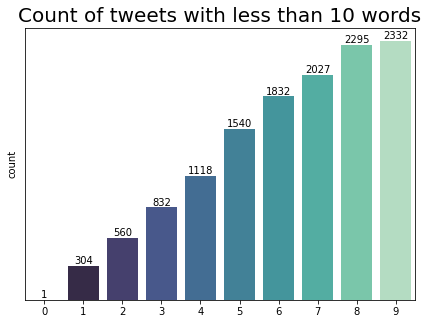

In [21]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [22]:
# checking long tweets
df.sort_values(by=['text_len'], ascending=False)

,text,sentiment,text_clean,text_len
44035,You so black and white trying to live like a n...,4,black white tri live like nigger pahahahaha co...,187
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",4,fuck obama dumb ass nigger bitch ltthi whore s...,162
33724,"... I don't feel guilty for killing him, I jus...",2,feel guilti kill feel guilti enjoy torment sin...,137
1317,@EurekAlertAAAS: Researchers push to import to...,5,research push import top antibulli program us ...,137
47037,@Purely_Ambition: Sooo mad. RT @TracePeterson ...,4,sooo mad rt fuck obama dumb nigger go switzerl...,125
...,...,...,...,...
1607,@harmlesstree2 Here7 https://t.co/xWJzpSodGj,5,here7,1
6696,@LiamTighe Rebecca who?,5,rebecca,1
558,@root_tim this is my work :),5,work,1
3462,@jaredchase killing you how?,5,kill,1


**Removing tweets with less than 4 words and more than 100 words as they can be outliers**

In [23]:
df = df[df['text_len'] > 3]
df = df[df['text_len'] < 100]

In [24]:
df

,text,sentiment,text_clean,text_len
0,"In other words #katandandre, your food was cra...",5,word katandandr food crapilici mkr,5
1,Why is #aussietv so white? #MKR #theblock #ImA...,5,aussietv white mkr theblock today sunris studi...,10
2,@XochitlSuckkks a classy whore? Or more red ve...,5,classi whore red velvet cupcak,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",5,meh p thank head concern anoth angri dude twitter,9
4,@RudhoeEnglish This is an ISIS account pretend...,5,isi account pretend kurdish account like islam...,8
...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",4,black ppl expect anyth depend anyth yet free p...,21
47688,Turner did not withhold his disappointment. Tu...,4,turner withhold turner call court abomin concl...,28
47689,I swear to God. This dumb nigger bitch. I have...,4,swear god dumb nigger bitch got bleach hair re...,13
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,4,yea fuck rt your nigger fuck unfollow fuck dum...,10


# Creating a word cloud

In [25]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt #to display our wordcloud
from PIL import Image #to load our image
import numpy as np #to get the color of our image

**0 - religion </br>
1 - age  </br> 
2 - gender </br>
3 - ethnicity </br>
4 - cyberbullying**

# Turning text into numbers

In [27]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline


tfidf = TfidfTransformer()
clf = CountVectorizer()

X_cv =  clf.fit_transform(df['text_clean'])

tf_transformer = TfidfTransformer(use_idf=True).fit(X_cv)
X_tf = tf_transformer.transform(X_cv)

In [28]:
X_tf

<37114x32979 sparse matrix of type '<class 'numpy.float64'>'
	with 504608 stored elements in Compressed Sparse Row format>

# Train test split

In [29]:
from sklearn.model_selection import train_test_split
# train and test
X_train, X_test, y_train, y_test = train_test_split(X_tf, df['sentiment'], test_size=0.20, stratify=df['sentiment'], random_state=42)

In [30]:
y_train.value_counts()

0    6314
1    6264
3    6167
2    5849
4    5097
Name: sentiment, dtype: int64

**after checking the training set, there are imbalance of data and it may cause a bias in training the model. Oversampling using SMOTE will be used to balance the train dataset.**

# SMOTE

In [31]:
from imblearn.over_sampling import SMOTE
vc = y_train.value_counts()
while (vc[0] != vc[4]) or (vc[0] !=  vc[2]) or (vc[0] !=  vc[3]) or (vc[0] !=  vc[1]):
    smote = SMOTE(sampling_strategy='minority')
    X_train, y_train = smote.fit_resample(X_train, y_train)
    vc = y_train.value_counts()

y_train.value_counts()

4    6314
0    6314
3    6314
2    6314
1    6314
Name: sentiment, dtype: int64

**Now the training set is balanced and ready to be feed into the ml model.**

# Model Training

## Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

# Model Evaluation

## **Classification Report**

In [36]:
from sklearn.metrics import classification_report
rf_pred = rf_clf.predict(X_test)
print('Classification Report for Random Forest:\n',classification_report(y_test, rf_pred, target_names=sentiments))

Classification Report for Random Forest:
                    precision    recall  f1-score   support

         religion       0.97      0.96      0.96      1579
              age       0.98      0.98      0.98      1566
           gender       0.96      0.87      0.91      1462
        ethnicity       0.99      0.99      0.99      1542
not_cyberbullying       0.80      0.89      0.85      1274

         accuracy                           0.94      7423
        macro avg       0.94      0.94      0.94      7423
     weighted avg       0.94      0.94      0.94      7423



## Confusion Matrix

In [37]:
#@title
from sklearn.metrics import confusion_matrix 
# Source code credit for this function: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

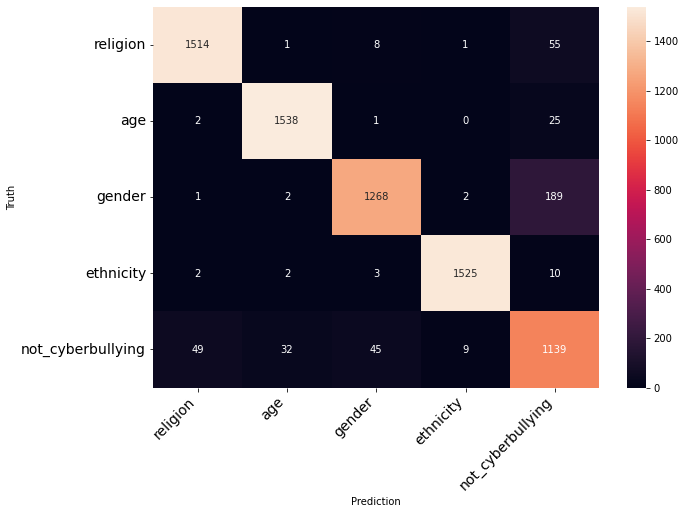

In [38]:
# Random Forest
cm = confusion_matrix(y_test,rf_pred)
print_confusion_matrix(cm,sentiments)

## Cross Validation Score

In [39]:
from sklearn.model_selection import cross_val_score

RF_cv_score = cross_val_score(rf_clf,X_train, y_train, cv=3)

print('Cross validation score (Random Forest Classifier):', RF_cv_score.mean())

Cross validation score (Random Forest Classifier): 0.9395629422457229
